## Detection of Diabetes

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlite3

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [58]:
data = pd.read_csv("../data/nhgh.tsv", sep = "\t")
data["gh"] = data["gh"].apply(lambda x: 1 if x >= 6.5 else 0)
x = data.drop("gh", axis=1)
y = data["gh"]

seed = 999

### SQLite3 Export

In [60]:
# Connect to SQLite database (create if not exists)
conn = sqlite3.connect("database.db")
cursor = conn.cursor()
table_name = "entries"

# Export DataFrame to SQLite database
data.to_sql(table_name, conn, index=False, if_exists="replace")

6795

### Data Preprocessing

##### Data Imputation Analysis

There are lots of missing values in the dataset, and to cope with this, we simply use the training dataset to fill the values for both the training and test dataset. I do not utilize the test dataset for imputation at all in order to respect its secrecy, as the training process must not look at the test dataset. For the numeric columns, it is very straightforward, as we can simply take the mean of the training data's respective column. On the contrary for the factor columns (income), we need to do some extra steps. 

<Axes: xlabel='income'>

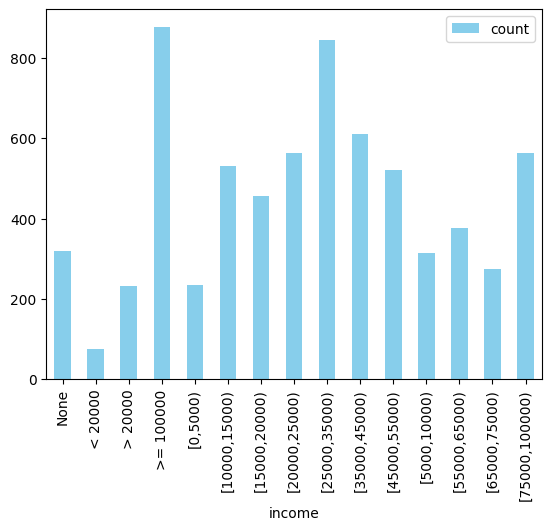

In [61]:
# Count the occurrences of each income
colname = "income"
income_frequency_query = f"""
SELECT {colname}, COUNT(*) as count
FROM {table_name}
GROUP BY {colname}
ORDER BY income ASC;
"""

counts = pd.read_sql_query(income_frequency_query, conn).set_index("income")
counts.plot(kind="bar", color="skyblue")

From the bar graph above, we can clearly see that taking the mode of the column won"t suffice, as the distribution of the income is quite varied. Thus, setting 1 level for all the missing values will be not be an option. Usually if the incompleteness is severe, we can use a model to predict the column based on the other features. But in the case of income, as the number of missing value is less than 5%, we can just create a new level called "UNKOWN".

##### Data Imbalance Analysis

<Axes: xlabel='gh'>

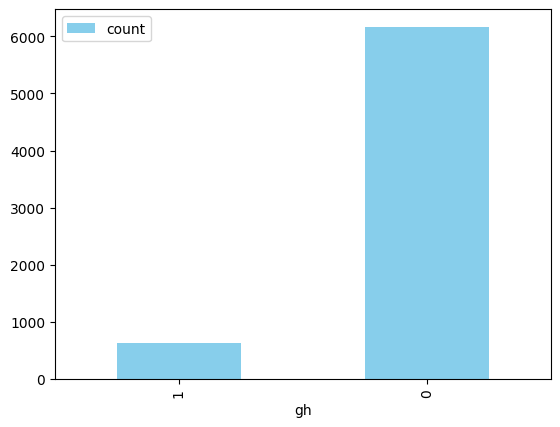

In [63]:
# Count the occurrences of gh
colname = "gh"
income_frequency_query = f"""
SELECT {colname}, COUNT(*) as count
FROM {table_name}
GROUP BY {colname}
ORDER BY income ASC;
"""

counts = pd.read_sql_query(income_frequency_query, conn).set_index("gh")
counts.plot(kind="bar", color="skyblue")

For the second analysis, we can see from the result above that the classes are hugely imbalanced in favor of the negative class. In other words, there is a limited number of diabetic people inside the data, and this can significantly affect how the classifier fits. In order to cope with this issue, we will utilize SMOTE, such that we can rack up the number of positive classes to be equal with the negatives by using synthetic data generation. 

##### Preprocessing Pipeline

In [19]:
# Impute missing income using "UNKOWN" flag
x["income"].fillna("UNKOWN", inplace = True)
x["income"].fillna("UNKOWN", inplace = True)

# Convert factors into One Hot Encoding
onehot_x = pd.get_dummies(x, columns=["sex", "re", "income"], drop_first=True)

# Split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(onehot_x, y, test_size=0.25, random_state=seed)

# Impute missing data using training data mean
x_train.fillna(x_train.mean(), inplace = True)
x_test.fillna(x_train.mean(), inplace = True)

smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x_train, y_train)

### Logistic Regression Model

##### Imbalanced Data

Best Hyperparameters for Logistic Regression: {'C': 100, 'max_iter': 2000, 'penalty': 'l2'}
Accuracy: 0.9034726309593879

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1537
           1       0.45      0.06      0.11       162

    accuracy                           0.90      1699
   macro avg       0.68      0.53      0.53      1699
weighted avg       0.87      0.90      0.87      1699



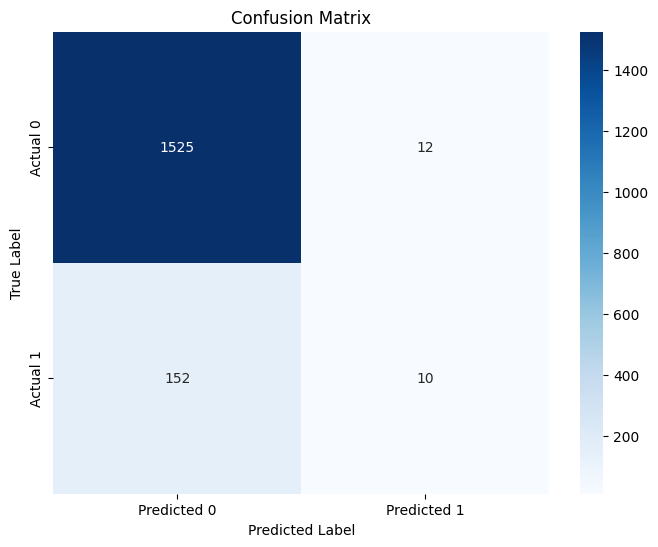

In [22]:
# Create a Logistic Regression model
lr = LogisticRegression(random_state=seed)

# Define hyperparameters to tune
lr_grid = {
    "penalty": ["l2"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter": [2000, 4000]
}

# Use GridSearchCV for hyperparameter tuning
lr_grid_search = GridSearchCV(estimator=lr, param_grid=lr_grid, cv=5, scoring="accuracy")
lr_grid_search.fit(x_train, y_train)
lr_best_model = lr_grid_search.best_estimator_

# Get the best hyperparameters
lr_best_params = lr_grid_search.best_params_
print("Best Hyperparameters for Logistic Regression:", lr_best_params)

# Evaluate the model
lr_best_pred = lr_best_model.predict(x_test)
lr_acc = accuracy_score(y_test, lr_best_pred)
lr_conf = confusion_matrix(y_test, lr_best_pred)
lr_report = classification_report(y_test, lr_best_pred)

print(f"Accuracy: {lr_acc}\n")
print(f"Classification Report:\n{lr_report}")
plt.figure(figsize=(8, 6))
sns.heatmap(lr_conf, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

##### SMOTE Data

Best Hyperparameters for Logistic Regression: {'C': 0.01, 'max_iter': 2000, 'penalty': 'l2'}
Accuracy: 0.7686874632136551

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      1537
           1       0.27      0.86      0.41       162

    accuracy                           0.77      1699
   macro avg       0.63      0.81      0.64      1699
weighted avg       0.91      0.77      0.81      1699



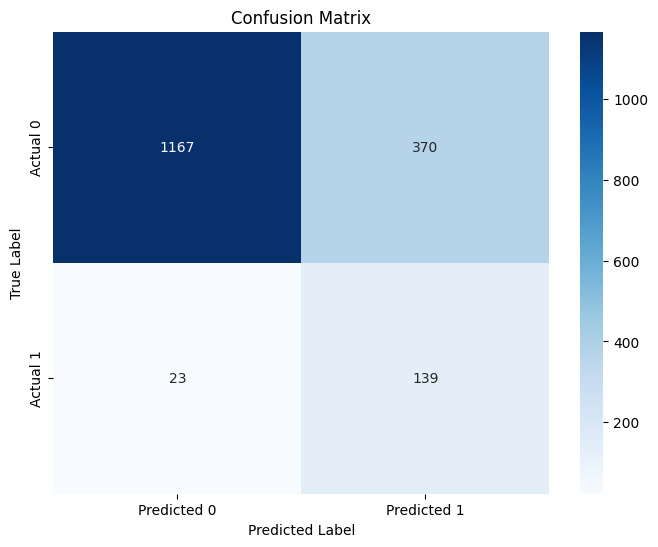

In [23]:
# Create a Logistic Regression model
lr_smote = LogisticRegression(random_state=seed)

# Define hyperparameters to tune
lr_smote_grid = {
    "penalty": ["l2"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter": [2000, 4000]
}

# Use GridSearchCV for hyperparameter tuning
lr_smote_grid_search = GridSearchCV(estimator=lr_smote, param_grid=lr_smote_grid, cv=5, scoring="accuracy")
lr_smote_grid_search.fit(x_smote, y_smote)
lr_smote_best_model = lr_smote_grid_search.best_estimator_

# Get the best hyperparameters
lr_smote_best_params = lr_smote_grid_search.best_params_
print("Best Hyperparameters for Logistic Regression:", lr_smote_best_params)

# Evaluate the model
lr_smote_best_pred = lr_smote_best_model.predict(x_test)
lr_smote_acc = accuracy_score(y_test, lr_smote_best_pred)
lr_smote_conf = confusion_matrix(y_test, lr_smote_best_pred)
lr_smote_report = classification_report(y_test, lr_smote_best_pred)

print(f"Accuracy: {lr_smote_acc}\n")
print(f"Classification Report:\n{lr_smote_report}")
plt.figure(figsize=(8, 6))
sns.heatmap(lr_smote_conf, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Decision Tree Model

##### Imbalanced Data

Best Hyperparameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Accuracy: 0.9358446144791054

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1537
           1       0.67      0.65      0.66       162

    accuracy                           0.94      1699
   macro avg       0.82      0.81      0.81      1699
weighted avg       0.93      0.94      0.94      1699



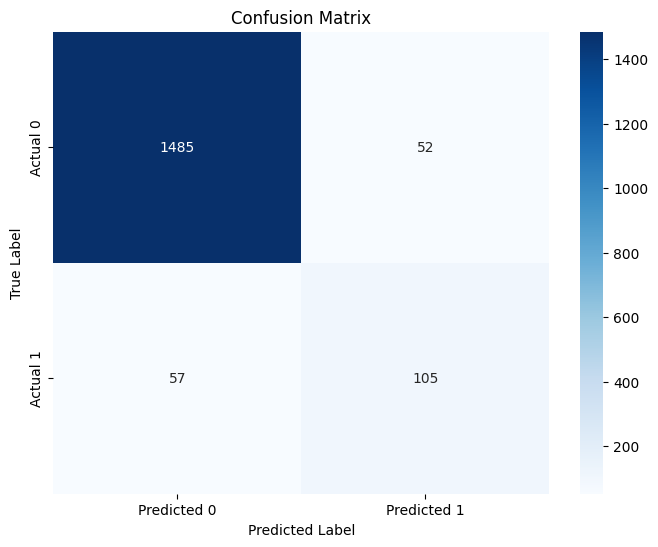

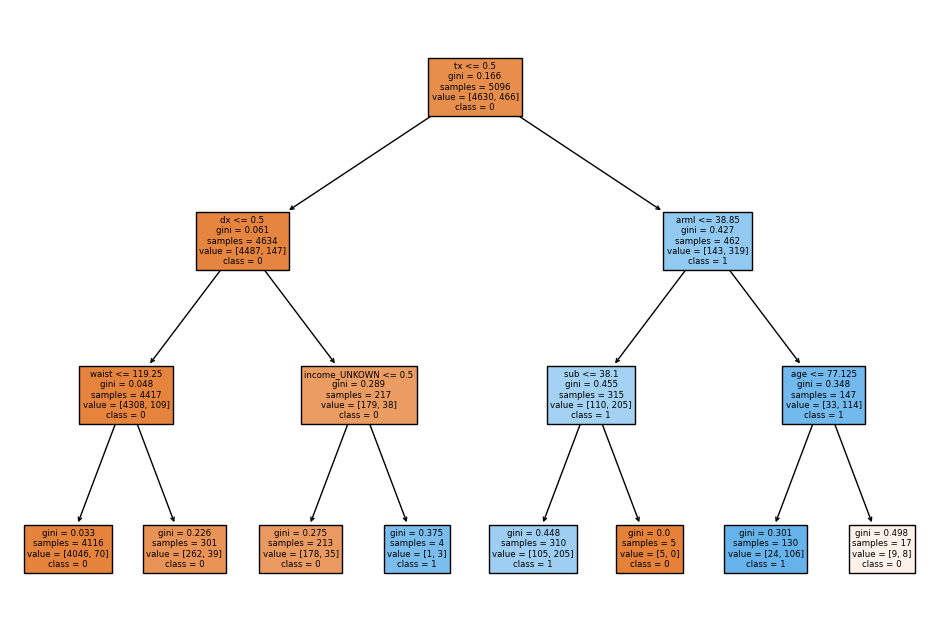

In [10]:
# Create a Decision Tree classifier
dt = DecisionTreeClassifier(random_state=seed)

# Define hyperparameters to tune
dt_grid = {
    "max_depth": [3, 4, 5, 6],
    "min_samples_leaf": [2, 3, 4, 5],
    "min_samples_split": [2, 5, 8]
}

# Use GridSearchCV for hyperparameter tuning
dt_grid_search = GridSearchCV(estimator=dt, param_grid=dt_grid, cv=5, scoring="accuracy")
dt_grid_search.fit(x_train, y_train)
dt_best_model = dt_grid_search.best_estimator_

# Get the best hyperparameters
dt_best_params = dt_grid_search.best_params_
print("Best Hyperparameters:", dt_best_params)

# Evaluate the model
dt_best_pred = dt_best_model.predict(x_test)
dt_acc = accuracy_score(y_test, dt_best_pred)
dt_conf = confusion_matrix(y_test, dt_best_pred)
dt_report = classification_report(y_test, dt_best_pred)

print(f"Accuracy: {dt_acc}\n")
print(f"Classification Report:\n{dt_report}")
plt.figure(figsize=(8, 6))
sns.heatmap(dt_conf, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_best_model, feature_names=x_train.columns, class_names=["0", "1"], filled=True)
plt.show()

##### SMOTE Data

Best Hyperparameters: {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2}
Accuracy: 0.8434373160682754

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1537
           1       0.35      0.72      0.47       162

    accuracy                           0.84      1699
   macro avg       0.66      0.79      0.69      1699
weighted avg       0.91      0.84      0.87      1699



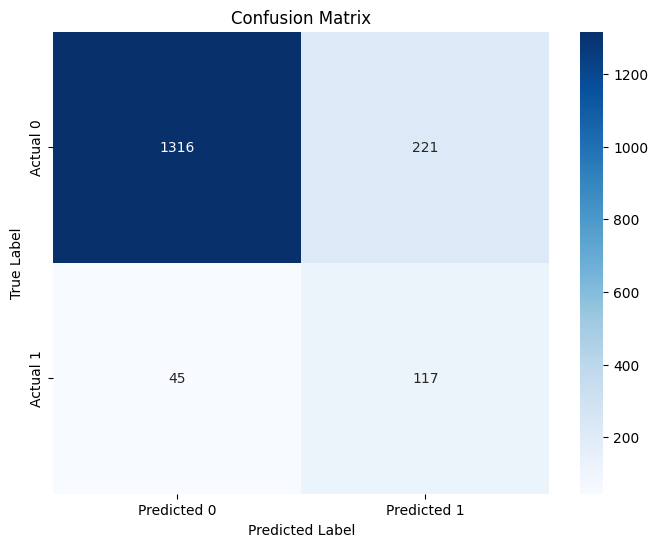

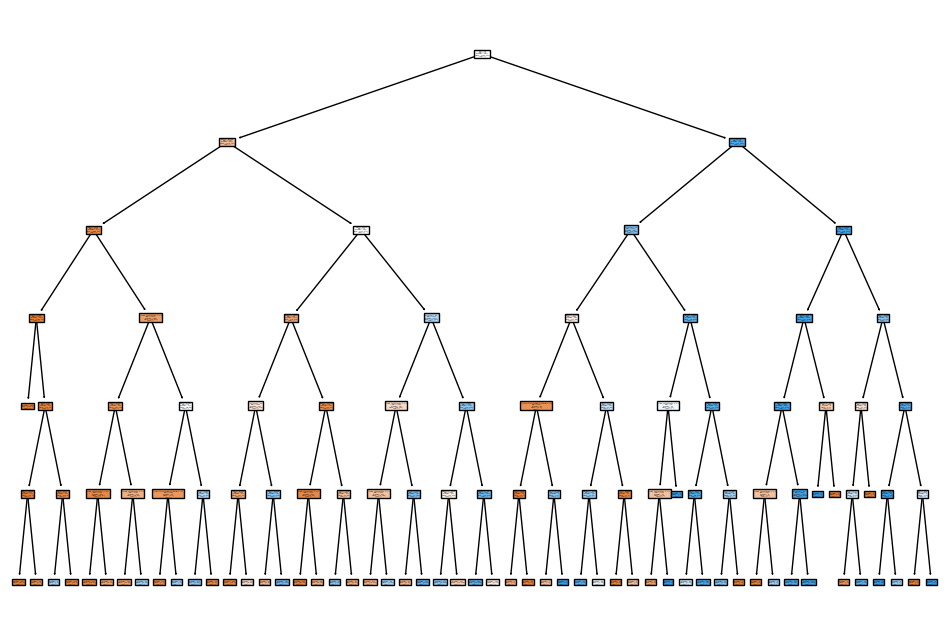

In [25]:
# Create a Decision Tree classifier
dt_smote = DecisionTreeClassifier(random_state=seed)

# Define hyperparameters to tune
dt_smote_grid = {
    "max_depth": [3, 4, 5, 6],
    "min_samples_leaf": [2, 3, 4, 5],
    "min_samples_split": [2, 5, 8]
}

# Use GridSearchCV for hyperparameter tuning
dt_smote_grid_search = GridSearchCV(estimator=dt_smote, param_grid=dt_smote_grid, cv=5, scoring="accuracy")
dt_smote_grid_search.fit(x_smote, y_smote)
dt_smote_best_model = dt_smote_grid_search.best_estimator_

# Get the best hyperparameters
dt_smote_best_params = dt_smote_grid_search.best_params_
print("Best Hyperparameters:", dt_smote_best_params)

# Evaluate the model
dt_smote_best_pred = dt_smote_best_model.predict(x_test)
dt_smote_acc = accuracy_score(y_test, dt_smote_best_pred)
dt_smote_conf = confusion_matrix(y_test, dt_smote_best_pred)
dt_smote_report = classification_report(y_test, dt_smote_best_pred)

print(f"Accuracy: {dt_smote_acc}\n")
print(f"Classification Report:\n{dt_smote_report}")
plt.figure(figsize=(8, 6))
sns.heatmap(dt_smote_conf, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_smote_best_model, feature_names=x_train.columns, class_names=["0", "1"], filled=True)
plt.show()

### Random Forest Model

##### Imbalanced Data

Best Hyperparameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.9334902884049441

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1537
           1       0.67      0.60      0.63       162

    accuracy                           0.93      1699
   macro avg       0.81      0.78      0.80      1699
weighted avg       0.93      0.93      0.93      1699



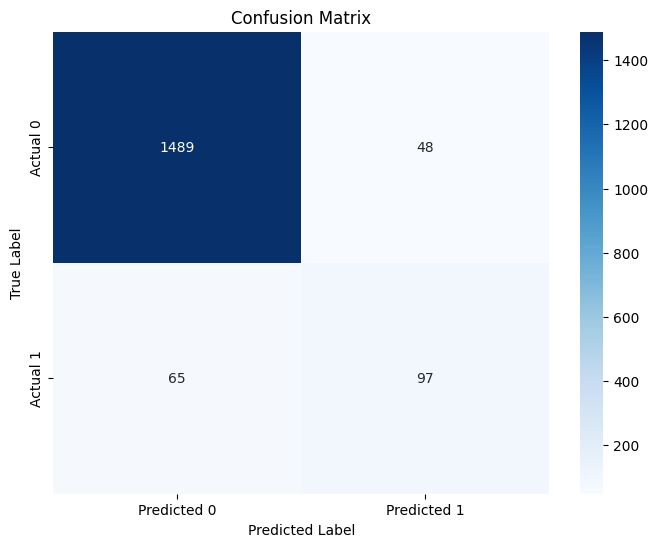

In [26]:
# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=seed)

rf_grid = {
    "n_estimators": [50, 150],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 4]
}

# Use GridSearchCV for hyperparameter tuning
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_grid, cv=5, scoring="accuracy")
rf_grid_search.fit(x_train, y_train)

# Get the best hyperparameters
rf_best_params = rf_grid_search.best_params_
print("Best Hyperparameters for Random Forest:", rf_best_params)

# Evaluate the model
rf_best_model = rf_grid_search.best_estimator_
rf_best_pred = rf_best_model.predict(x_test)
rf_acc = accuracy_score(y_test, rf_best_pred)
rf_conf = confusion_matrix(y_test, rf_best_pred)
rf_report = classification_report(y_test, rf_best_pred)

print(f"Accuracy: {rf_acc}\n")
print(f"Classification Report:\n{rf_report}")
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

##### SMOTE Data

Best Hyperparameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.9117127722189523

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1537
           1       0.53      0.68      0.59       162

    accuracy                           0.91      1699
   macro avg       0.75      0.81      0.77      1699
weighted avg       0.92      0.91      0.92      1699



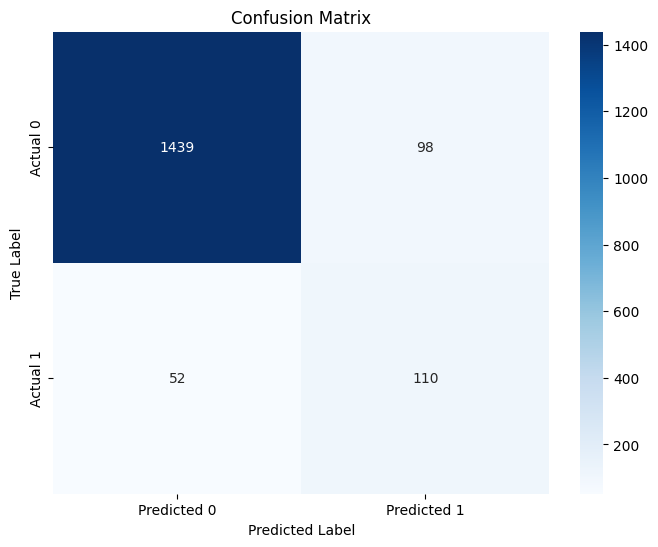

In [27]:
# Create a Random Forest classifier
rf_smote = RandomForestClassifier(random_state=seed)

rf_smote_grid = {
    "n_estimators": [50, 150],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 4]
}

# Use GridSearchCV for hyperparameter tuning
rf_smote_grid_search = GridSearchCV(estimator=rf_smote, param_grid=rf_smote_grid, cv=5, scoring="accuracy")
rf_smote_grid_search.fit(x_smote, y_smote)

# Get the best hyperparameters
rf_smote_best_params = rf_smote_grid_search.best_params_
print("Best Hyperparameters for Random Forest:", rf_smote_best_params)

# Evaluate the model
rf_smote_best_model = rf_smote_grid_search.best_estimator_
rf_smote_best_pred = rf_smote_best_model.predict(x_test)
rf_smote_acc = accuracy_score(y_test, rf_smote_best_pred)
rf_smote_conf = confusion_matrix(y_test, rf_smote_best_pred)
rf_smote_report = classification_report(y_test, rf_smote_best_pred)

print(f"Accuracy: {rf_smote_acc}\n")
print(f"Classification Report:\n{rf_smote_report}")
plt.figure(figsize=(8, 6))
sns.heatmap(rf_smote_conf, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()